In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,f1_score,confusion_matrix,precision_score,roc_curve,roc_auc_score,auc,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder 
from sklearn.utils import shuffle
from sklearn.utils import resample


# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

# To make this notebook's output stable across runs
seed = 50
np.random.seed(seed)

import ipaddress
import time


## NetFlow Feature Analysis based on Previous Works

In [2]:
superset = pd.read_csv("Data Sets/superset.csv")
superset.head()

,Field,Binary Tally,Multi-Classification Tally,Total Tally
0,FLOW_DURATION_MILLISECONDS,2.0,2.0,4
1,TCP_WIN_MAX_IN,3.0,3.0,6
2,DURATION_OUT,2.0,1.0,3
3,MAX_TTL,2.0,1.0,3
4,L7_PROTO,2.0,2.0,4


In [3]:
tallyBinary = superset.sort_values(by=["Total Tally"],ascending=False)
print(tallyBinary)

                          Field  Binary Tally  Multi-Classification Tally  \
1                TCP_WIN_MAX_IN           3.0                         3.0   
6             SHORTEST_FLOW_PKT           2.0                         3.0   
0    FLOW_DURATION_MILLISECONDS           2.0                         2.0   
16               MAX_IP_PKT_LEN           2.0                         2.0   
8               TCP_WIN_MAX_OUT           1.0                         3.0   
9                     OUT_BYTES           1.0                         3.0   
5     SRC_TO_DST_AVG_THROUGHPUT           2.0                         2.0   
4                      L7_PROTO           2.0                         2.0   
7                MIN_IP_PKT_LEN           1.0                         2.0   
3                       MAX_TTL           2.0                         1.0   
2                  DURATION_OUT           2.0                         1.0   
27                 DNS_QUERY_ID           1.0                         1.0   

In [58]:
tallyBinary = superset.sort_values(by=["Binary Tally"],ascending=False)
print(tallyBinary)

                          Field  Binary Tally  Multi-Classification Tally  \
1                TCP_WIN_MAX_IN           3.0                         3.0   
0    FLOW_DURATION_MILLISECONDS           2.0                         2.0   
16               MAX_IP_PKT_LEN           2.0                         2.0   
2                  DURATION_OUT           2.0                         1.0   
3                       MAX_TTL           2.0                         1.0   
4                      L7_PROTO           2.0                         2.0   
5     SRC_TO_DST_AVG_THROUGHPUT           2.0                         2.0   
6             SHORTEST_FLOW_PKT           2.0                         3.0   
26  NUM_PKTS_1024_TO_1514_BYTES           1.0                         1.0   
25       RETRANSMITTED_OUT_PKTS           1.0                         1.0   
24                      IN_PKTS           1.0                         1.0   
23                     PROTOCOL           1.0                         1.0   

In [59]:
tallyMC = superset.sort_values(by=["Multi-Classification Tally"],ascending=False)
tallyMC.head()

,Field,Binary Tally,Multi-Classification Tally,Total Tally
9,OUT_BYTES,1.0,3.0,4
1,TCP_WIN_MAX_IN,3.0,3.0,6
8,TCP_WIN_MAX_OUT,1.0,3.0,4
6,SHORTEST_FLOW_PKT,2.0,3.0,5
7,MIN_IP_PKT_LEN,1.0,2.0,3


In [60]:
tallyBoth = superset.sort_values(by=["Binary Tally","Multi-Classification Tally"],ascending=False)
print(tallyBoth)

                          Field  Binary Tally  Multi-Classification Tally  \
1                TCP_WIN_MAX_IN           3.0                         3.0   
6             SHORTEST_FLOW_PKT           2.0                         3.0   
0    FLOW_DURATION_MILLISECONDS           2.0                         2.0   
4                      L7_PROTO           2.0                         2.0   
5     SRC_TO_DST_AVG_THROUGHPUT           2.0                         2.0   
16               MAX_IP_PKT_LEN           2.0                         2.0   
2                  DURATION_OUT           2.0                         1.0   
3                       MAX_TTL           2.0                         1.0   
8               TCP_WIN_MAX_OUT           1.0                         3.0   
9                     OUT_BYTES           1.0                         3.0   
7                MIN_IP_PKT_LEN           1.0                         2.0   
10      SRC_TO_DST_SECOND_BYTES           1.0                         1.0   

## Preparing Data Set

In [3]:
#Importing dataset
netFlowDataset = []
netFlowDataset = pd.read_csv("Data Sets/NF-ToN-IoT-v2/NF-ToN-IoT-v2.csv")
netFlowDataset.head(10)

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,192.168.1.193,49235,192.168.1.33,4444,6,0.000,155392,202,34552,149,...,45555,4805,0,0,0,0,0,0,1,ransomware
1,192.168.1.193,49228,192.168.1.152,1880,6,0.000,1600,40,35741,65,...,16425,237,0,0,0,0,0,0,0,Benign
2,192.168.1.152,0,192.168.1.193,0,1,0.000,212,2,0,0,...,0,0,771,3,0,0,0,0,0,Benign
3,192.168.1.169,65317,239.255.255.250,1900,17,0.000,165,1,0,0,...,0,0,0,0,0,0,0,0,0,Benign
4,192.168.1.79,60766,192.168.1.255,15600,17,0.000,63,1,0,0,...,0,0,0,0,0,0,0,0,0,Benign
5,192.168.1.193,137,192.168.1.33,137,17,0.000,234,3,0,0,...,0,0,0,0,0,0,0,0,1,ransomware
6,192.168.1.33,0,192.168.1.193,0,1,0.000,318,3,0,0,...,0,0,771,3,0,0,0,0,0,Benign
7,192.168.1.133,52729,239.255.255.250,1900,17,0.000,459,3,0,0,...,0,0,0,0,0,0,0,0,0,Benign
8,192.168.1.193,49233,172.217.167.67,80,6,7.126,121,3,92,2,...,16381,242,0,0,0,0,0,0,0,Benign
9,192.168.1.79,44596,239.255.255.250,15600,17,0.000,63,1,0,0,...,0,0,0,0,0,0,0,0,0,Benign


In [ ]:
# Encoding the classes to integers
le = LabelEncoder()
le.fit(netFlowDataset["Attack"])
attackLabelMapping = dict(zip(le.classes_, le.transform(le.classes_)))

netFlowAttacks = le.fit_transform(netFlowDataset["Attack"])

attackLabelMapping = dict((v, k) for k, v in attackLabelMapping.items())

binaryClassificationLabels = ['Class 0: Benign', 'Class 1: Attack']
multiClassificationLabels = ["Class " + 
                            str(i) + ": " + 
                            attackLabelMapping[i] 
                            for i in range(len(attackLabelMapping))]

In [4]:
def showDistribution(classLabels, target, noOfClasses):
    # Check distribution/ratio
    N, bins, patches = plt.hist(target, noOfClasses, ec = 'k')

    # Change colors of columns
    # Numbers are based on the `jet` colormap for now
    cmap = plt.get_cmap('viridis')
    # List of colors for each bin/column/class
    uniqueCMaps = [cmap((1/noOfClasses)*i) for i in range(noOfClasses)]

    # Set the colors of bars by the order in which they appear from left to right
    for i in range(noOfClasses):
        # Each bar's color is being set from 0.1 to 1.0 in increments depending
        # on the number of classes (see uniqueCMaps above)
        patches[i].set_facecolor(uniqueCMaps[i])

    # Create a legend for the plot
    # See matplotlib documentation for syntax: https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
    handles = [Rectangle((0,0), 1, 1, color = c, ec = "k") for c in uniqueCMaps]

    # Labels for the bins
    binLabels = [i for i in range(noOfClasses + 1)]
    # Modifies font size of the legend labels
    plt.legend(handles, classLabels, prop = {'size' : 10}, loc="best")

    # Creating labels for each bin in the histogram for readability
    plt.xticks(bins, labels = binLabels)

    # Labelling the histogram
    plt.xlabel('Class')
    plt.ylabel('Number of instances')
    plt.title('Target classes')

    plt.show()

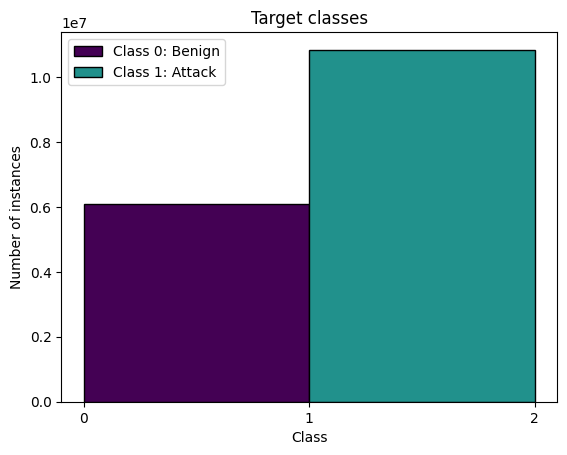

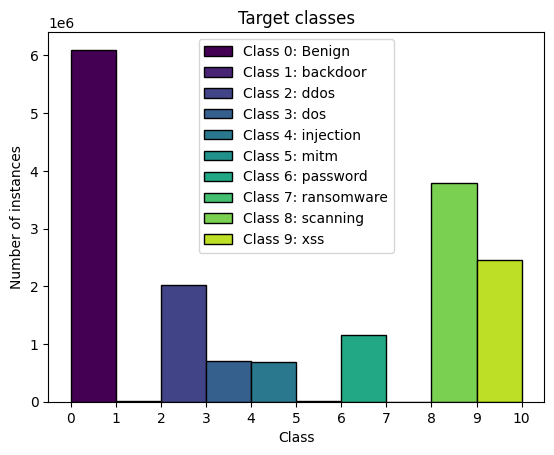

In [5]:
showDistribution(binaryClassificationLabels,netFlowDataset["Label"],2)
showDistribution(multiClassificationLabels,netFlowAttacks,10)

In [6]:
underSampledNFD = pd.DataFrame(columns=netFlowDataset.columns)

majorityClasses = ["Benign", "scanning", "xss", "ddos", "password", "dos", "injection"]
minorityClasses = ["backdoor","mitm","ransomware"]

prop = 0.4

classCounts = netFlowDataset['Attack'].value_counts()
print("Multi-class counts before under sampling:")
print(classCounts)
print("\nBinary counts before under sampling:")
print(netFlowDataset['Label'].value_counts())

for label, count in classCounts.items():
    currentClass = netFlowDataset[netFlowDataset["Attack"] == label]
    if label in majorityClasses:
        underSampledClass = resample(currentClass, replace=False, n_samples=int(count * prop), random_state=50)
        underSampledNFD = pd.concat([underSampledNFD, underSampledClass])
    else:
        underSampledNFD = pd.concat([underSampledNFD, currentClass])


print("#######################################")
underSampledNFD = underSampledNFD.reset_index(drop=True)
print("Multi-class after under sampling:")
print(underSampledNFD['Attack'].value_counts())
print("\nBinary counts after under sampling:")
print(underSampledNFD['Label'].value_counts())

Multi-class counts before under sampling:
Attack
Benign        6099469
scanning      3781419
xss           2455020
ddos          2026234
password      1153323
dos            712609
injection      684465
backdoor        16809
mitm             7723
ransomware       3425
Name: count, dtype: int64

Binary counts before under sampling:
Label
1    10841027
0     6099469
Name: count, dtype: int64
#######################################
Multi-class after under sampling:
Attack
Benign        2439787
scanning      1512567
xss            982008
ddos           810493
password       461329
dos            285043
injection      273786
backdoor        16809
mitm             7723
ransomware       3425
Name: count, dtype: int64

Binary counts after under sampling:
Label
1    4353183
0    2439787
Name: count, dtype: int64


In [7]:
netFlowDataset =  underSampledNFD
underSampledNFD = []

In [4]:
netFlowDataset = netFlowDataset.sample(frac=1, random_state=50).reset_index(drop=True)
netFlowDataset.head(10)

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,192.168.1.39,39124,192.168.1.1,53,17,0.0,65,1,65,1,...,0,0,0,0,54488,28,0,0,1,xss
1,192.168.1.31,55660,192.168.1.190,80,6,7.0,572,5,1332,3,...,29200,28960,0,0,0,0,0,0,1,password
2,172.17.0.5,34986,192.168.1.190,53,17,0.0,118,2,268,2,...,0,0,0,0,30333,1,1409,0,0,Benign
3,192.168.1.31,51649,192.168.1.49,8008,6,161.0,44,1,0,0,...,1024,0,0,0,0,0,0,0,0,Benign
4,192.168.1.34,36073,192.168.1.152,23502,6,0.0,44,1,40,1,...,1024,0,0,0,0,0,0,0,0,Benign
5,192.168.1.31,51635,192.168.1.180,6668,6,0.0,44,1,0,0,...,1024,0,0,0,0,0,0,0,0,Benign
6,192.168.1.31,62320,192.168.1.180,5225,6,0.0,44,1,0,0,...,1024,0,0,0,0,0,0,0,0,Benign
7,192.168.1.32,24073,192.168.1.194,53649,6,0.0,48,1,0,0,...,4096,0,0,0,0,0,0,0,1,scanning
8,192.168.1.34,40638,192.168.1.180,50003,6,0.0,44,1,0,0,...,1024,0,0,0,0,0,0,0,0,Benign
9,192.168.1.30,40803,192.168.1.49,100,6,0.0,44,1,0,0,...,1024,0,0,0,0,0,0,0,0,Benign


In [ ]:
netFlowLabels = netFlowDataset.pop("Label")
netFlowAttacks = netFlowDataset.pop("Attack")

In [6]:
le = LabelEncoder()
netFlowAttacks = le.fit_transform(netFlowAttacks)

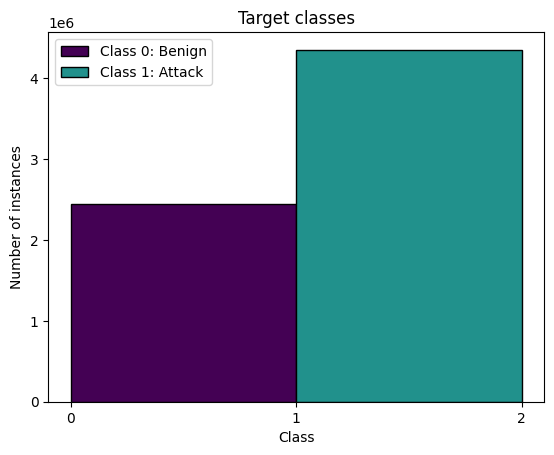

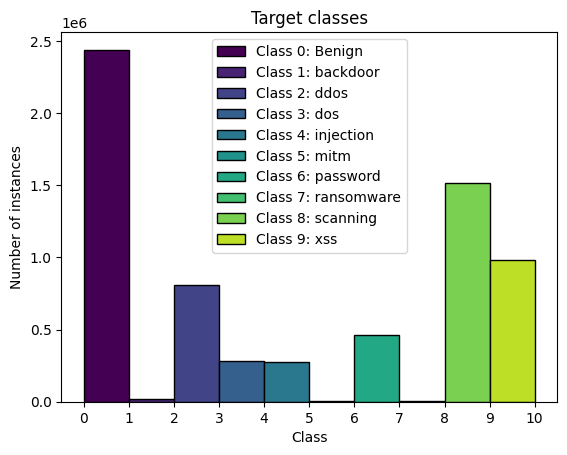

In [10]:
showDistribution(binaryClassificationLabels,netFlowLabels,2)
showDistribution(multiClassificationLabels,netFlowAttacks,10)

In [7]:
# Enumerating IP Addresses
def ip_to_integer(ip):
    return int(ipaddress.IPv4Address(ip))

netFlowDataset["IPV4_SRC_ADDR"] = netFlowDataset["IPV4_SRC_ADDR"].apply(ip_to_integer)
netFlowDataset["IPV4_DST_ADDR"] = netFlowDataset["IPV4_DST_ADDR"].apply(ip_to_integer)

In [8]:
np.max(netFlowDataset["SRC_TO_DST_SECOND_BYTES"])

8.912111521067714e+304

In [9]:
netFlowDataset["SRC_TO_DST_SECOND_BYTES"] = netFlowDataset["SRC_TO_DST_SECOND_BYTES"].astype("float32")
netFlowDataset["DST_TO_SRC_SECOND_BYTES"] = netFlowDataset["DST_TO_SRC_SECOND_BYTES"].astype("float32")

In [10]:
np.max(netFlowDataset["SRC_TO_DST_SECOND_BYTES"])

inf

In [11]:
netFlowDataset.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE'],
      dtype='object')

In [12]:
netFlowDataset.size

728441328

In [13]:
netFlowDataset.replace(np.inf, np.finfo(np.float32).max, inplace=True)

In [14]:
np.max(netFlowDataset["SRC_TO_DST_SECOND_BYTES"])

3.4028235e+38

In [19]:
initial_rows = len(netFlowDataset)
netFlowDataset = netFlowDataset.dropna()  # Drop rows with missing values
cleaned_rows = len(netFlowDataset)
print(f"Rows removed during N\A cleaning process: {initial_rows - cleaned_rows}")
initial_rows = len(netFlowDataset)
netFlowDataset = netFlowDataset.drop_duplicates()  # Drop duplicate rows
cleaned_rows = len(netFlowDataset)
print(f"Rows removed during duplicate row cleaning process: {initial_rows - cleaned_rows}")
netFlowDataset.reset_index(drop=True, inplace=True)

Rows removed during N\A cleaning process: 0
Rows removed during duplicate row cleaning process: 0


In [20]:
netFlowAttacks = pd.DataFrame(netFlowAttacks, columns=["Attack"])

In [21]:
netFlowDataset.to_csv("Data Sets/NF-ToN-IoT-v2-Processed", index=False)
netFlowAttacks.to_csv("Data Sets/NF-ToN-IoT-v2-Processed-Attacks", index=False)
netFlowLabels.to_csv("Data Sets/NF-ToN-IoT-v2-Processed-Labels", index=False)

## Importing Dataset

In [2]:
netFlowDataset = pd.read_csv("Data Sets/NF-ToN-IoT-v2-Processed")
netFlowAttacks = pd.read_csv("Data Sets/NF-ToN-IoT-v2-Processed-Attacks")
netFlowLabels= pd.read_csv("Data Sets/NF-ToN-IoT-v2-Processed-Labels")

In [5]:
# For Neural Networks
netFlowDatasetScaled = pd.read_csv("Data Sets/NF-ToN-IoT-v2-Scaled")
netFlowAttacks = pd.read_csv("Data Sets/NF-ToN-IoT-v2-Processed-Attacks")
netFlowLabels= pd.read_csv("Data Sets/NF-ToN-IoT-v2-Processed-Labels")

In [3]:
le = LabelEncoder()
netFlowAttacks = le.fit_transform(netFlowAttacks)

In [17]:
binaryClassificationLabels = ['Class 0: Benign', 'Class 1: Attack']

multiClassificationLabels = ['Class 0: Benign',
 'Class 1: backdoor',
 'Class 2: ddos',
 'Class 3: dos',
 'Class 4: injection',
 'Class 5: mitm',
 'Class 6: password',
 'Class 7: ransomware',
 'Class 8: scanning',
 'Class 9: xss']

In [18]:
allFeatures = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE']

# 12 Features proposed by paper 18 for Binary classification
paper18BinFeatures = ["PROTOCOL", "IN_PKTS", "TCP_FLAGS", "SERVER_TCP_FLAGS", "DURATION_OUT", "MAX_TTL","MAX_IP_PKT_LEN", "RETRANSMITTED_OUT_PKTS", "DST_TO_SRC_AVG_THROUGHPUT", "NUM_PKTS_1024_TO_1514_BYTES","TCP_WIN_MAX_IN", "DNS_QUERY_ID"]

# 14 Features proposed by paper 18 for Multi classification
paper18MultiFeatures = ["PROTOCOL", "IN_PKTS", "OUT_BYTES", "TCP_FLAGS", "CLIENT_TCP_FLAGS", "SERVER_TCP_FLAGS", "SHORTEST_FLOW_PKT", "MAX_IP_PKT_LEN", "RETRANSMITTED_OUT_PKTS", "NUM_PKTS_1024_TO_1514_BYTES", "TCP_WIN_MAX_IN", "TCP_WIN_MAX_OUT", "ICMP_TYPE", "DNS_QUERY_ID"]

# 10 Features proposed by paper 19 -both- How to Effectively Collect and Process Network Data for Intrusion Detection? - 10 features
# index = [14,35,15,17,5,28,19,20,36,8]
paper19Features = ["FLOW_DURATION_MILLISECONDS", "TCP_WIN_MAX_IN", "DURATION_OUT", "MAX_TTL", "L7_PROTO", "SRC_TO_DST_AVG_THROUGHPUT", "SHORTEST_FLOW_PKT", "MIN_IP_PKT_LEN", "TCP_WIN_MAX_OUT", "OUT_BYTES"]

# 13 Features proposed by Paper 20 - Examining the Suitability of NetFlow Features in Detecting IoT Network Intrusion - 13 features for binary classification
# index = [22,18,3,35,6,5,0,2,21,28,1,13,19]
paper20BinFeatures = ["SRC_TO_DST_SECOND_BYTES", "LONGEST_FLOW_PKT", "L4_DST_PORT", "TCP_WIN_MAX_IN", "IN_BYTES", "L7_PROTO", "IPV4_SRC_ADDR", "IPV4_DST_ADDR", "MAX_IP_PKT_LEN", "SRC_TO_DST_AVG_THROUGHPUT", "L4_SRC_PORT", "FLOW_DURATION_MILLISECONDS","SHORTEST_FLOW_PKT"]

# Features proposed by Paper 20 - Examining the Suitability of NetFlow Features in Detecting IoT Network Intrusion - 13 features for Multi-Classification
paper20MultiFeatures = ["LONGEST_FLOW_PKT", "IN_BYTES", "MAX_IP_PKT_LEN", "SRC_TO_DST_SECOND_BYTES", "L4_DST_PORT", "SRC_TO_DST_AVG_THROUGHPUT", "L7_PROTO", 'TCP_WIN_MAX_IN', "IPV4_DST_ADDR", "DST_TO_SRC_SECOND_BYTES", "SHORTEST_FLOW_PKT", "OUT_BYTES", "MIN_IP_PKT_LEN", "FLOW_DURATION_MILLISECONDS", "DST_TO_SRC_AVG_THROUGHPUT", "CLIENT_TCP_FLAGS", "L4_SRC_PORT", "TCP_WIN_MAX_OUT"]

In [14]:
nerfedpaper19Features = ["FLOW_DURATION_MILLISECONDS", "DURATION_OUT", "MAX_TTL", "SRC_TO_DST_AVG_THROUGHPUT", "SHORTEST_FLOW_PKT", "MIN_IP_PKT_LEN", "OUT_BYTES"]

In [19]:
proposedBinarySubsets = [allFeatures, 
                        paper18BinFeatures, 
                        paper19Features, 
                        paper20BinFeatures]
proposedMultiSubsets = [allFeatures, 
                        paper18MultiFeatures,
                        paper19Features, 
                        paper20MultiFeatures]

In [20]:
binaryTextLabels = ["All 43 Features - Binary Classification", 
                    "Binary Classification - Paper 18",
                    "Binary Classification - Paper 19",
                    "Binary Classification - Paper 20"]
multiTextLabels = [ "All 43 Features - Multi-Classification",
                    "Multi-Classification - Paper 18",
                    "Multi-Classification - Paper 19",
                    "Multi-Classification - Paper 20"]

Training Time: 64.14437913894653s
Prediction Time for 5082149 records: 4.950005292892456s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       1.00      0.99      0.99   1829841
Class 1: Attack       1.00      1.00      1.00   3252308

       accuracy                           1.00   5082149
      macro avg       1.00      1.00      1.00   5082149
   weighted avg       1.00      1.00      1.00   5082149



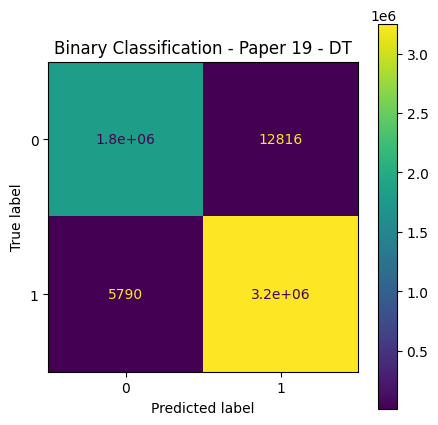

In [21]:
model = evaluateModel(DecisionTreeClassifier(), netFlowDataset[paper19Features], netFlowLabels, binaryClassificationLabels, binaryTextLabels[2] + " - DT",True)

In [23]:
from joblib import dump

In [24]:
dump(model,'L1Classifier.joblib')

['L1Classifier.joblib']

Training Time: 52.76816439628601s
Prediction Time for 5082149 records: 6.68343186378479s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       1.00      0.99      0.99   1829841
  Class 1: backdoor       1.00      0.99      0.99      5043
      Class 2: ddos       0.99      0.98      0.99    607870
       Class 3: dos       0.90      0.93      0.91    213783
 Class 4: injection       0.94      0.89      0.91    205339
      Class 5: mitm       0.89      0.36      0.51      2317
  Class 6: password       0.97      0.97      0.97    345997
Class 7: ransomware       0.96      0.97      0.96      1027
  Class 8: scanning       1.00      1.00      1.00   1134426
       Class 9: xss       0.95      0.97      0.96    736506

           accuracy                           0.98   5082149
          macro avg       0.96      0.90      0.92   5082149
       weighted avg       0.98      0.98      0.98  

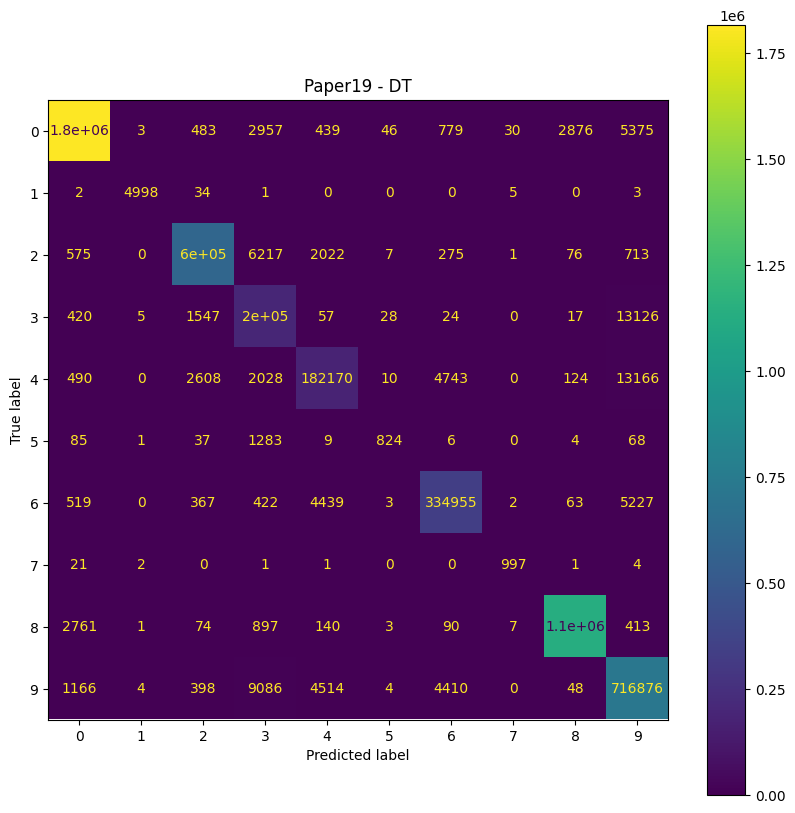

['L2Classifier.joblib']

In [26]:
model = evaluateModel(DecisionTreeClassifier(), netFlowDataset[paper19Features], netFlowAttacks, multiClassificationLabels, "Paper19 - DT",False)
dump(model,'L2Classifier.joblib')

In [25]:
sklearn.__version__

'1.4.1.post1'

## Decision Tree & Random Forest

In [15]:
# Model Imports
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

In [19]:
def evaluateModelCV(model, dataset, labels, displayLabels, name, bin):
    skf = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)
    
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    
    cv_results = cross_validate(model, dataset, labels, cv=skf, scoring=scoring)
    
    print(f"{name} - Cross Validation Results:")
    for metric in scoring:
        mean_score = np.mean(cv_results[f'test_{metric}'])
        print(f"{metric.capitalize()}: {mean_score:.4f}")

In [11]:
# Decision Tree Classifier - Binary
counter = 0
for subset in proposedBinarySubsets:
    print("###############################################################")
    print(binaryTextLabels[counter] + " - DT")
    print("###############################################################")
    evaluateModelCV(DecisionTreeClassifier(), netFlowDataset[subset], netFlowLabels, binaryClassificationLabels, binaryTextLabels[counter] + " - DT",True)
    counter = counter + 1

###############################################################
All 43 Features - Binary Classification - DT
###############################################################
All 43 Features - Binary Classification - DT - Cross Validation Results:
Accuracy: 0.9958
Precision_macro: 0.9954
Recall_macro: 0.9955
F1_macro: 0.9954
###############################################################
Binary Classification - Paper 18 - DT
###############################################################
Binary Classification - Paper 18 - DT - Cross Validation Results:
Accuracy: 0.9476
Precision_macro: 0.9372
Recall_macro: 0.9544
F1_macro: 0.9443
###############################################################
Binary Classification - Paper 19 - DT
###############################################################
Binary Classification - Paper 19 - DT - Cross Validation Results:
Accuracy: 0.9960
Precision_macro: 0.9960
Recall_macro: 0.9952
F1_macro: 0.9956
#####################################################

In [12]:
# Decision Tree Classifier - Multi
counter = 0
for subset in proposedMultiSubsets:
    print("###############################################################")
    print(multiTextLabels[counter] + " - DT")
    print("###############################################################")
    evaluateModelCV(DecisionTreeClassifier(), netFlowDataset[subset], netFlowAttacks, multiClassificationLabels, multiTextLabels[counter] + " - DT",False)
    counter = counter + 1

###############################################################
All 43 Features - Multi-Classification - DT
###############################################################
All 43 Features - Multi-Classification - DT - Cross Validation Results:
Accuracy: 0.9756
Precision_macro: 0.9259
Recall_macro: 0.9276
F1_macro: 0.9267
###############################################################
Multi-Classification - Paper 18 - DT
###############################################################
Multi-Classification - Paper 18 - DT - Cross Validation Results:
Accuracy: 0.9146
Precision_macro: 0.8779
Recall_macro: 0.8510
F1_macro: 0.8622
###############################################################
Multi-Classification - Paper 19 - DT
###############################################################
Multi-Classification - Paper 19 - DT - Cross Validation Results:
Accuracy: 0.9789
Precision_macro: 0.9569
Recall_macro: 0.9041
F1_macro: 0.9192
###########################################################

In [53]:
# Create the Random Forest model
rfModel = RandomForestClassifier(n_estimators=200,
                                   max_depth=8,
                                   criterion="entropy")

In [54]:
# Random Forest Classifier - Binary
counter = 0
for subset in proposedBinarySubsets:
    print("###############################################################")
    print(binaryTextLabels[counter] + "- RF")
    print("###############################################################")
    evaluateModelCV(rfModel, netFlowDataset[subset], netFlowLabels, binaryClassificationLabels, binaryTextLabels[counter] + " - RF", True)
    counter = counter + 1

###############################################################
All 43 Features - Binary Classification- RF
###############################################################
All 43 Features - Binary Classification - RF - Cross Validation Results:
Accuracy: 0.9807
Precision_macro: 0.9780
Recall_macro: 0.9801
F1_macro: 0.9791
###############################################################
Binary Classification - Paper 18- RF
###############################################################
Binary Classification - Paper 18 - RF - Cross Validation Results:
Accuracy: 0.9434
Precision_macro: 0.9331
Recall_macro: 0.9489
F1_macro: 0.9397
###############################################################
Binary Classification - Paper 19- RF
###############################################################
Binary Classification - Paper 19 - RF - Cross Validation Results:
Accuracy: 0.9789
Precision_macro: 0.9806
Recall_macro: 0.9737
F1_macro: 0.9770
########################################################

In [15]:
# Random Forest Classifier - Multi
counter = 0
for subset in proposedMultiSubsets:
    print("###############################################################")
    print(multiTextLabels[counter] + "- RF")
    print("###############################################################")
    evaluateModelCV(rfModel, netFlowDataset[subset], netFlowAttacks, multiClassificationLabels, multiTextLabels[counter] + " - RF", False)
    counter = counter + 1

###############################################################
All 43 Features - Multi-Classification- RF
###############################################################
All 43 Features - Multi-Classification - RF - Cross Validation Results:
Accuracy: 0.9338
Precision_macro: 0.9444
Recall_macro: 0.8069
F1_macro: 0.8455
###############################################################
Multi-Classification - Paper 18- RF
###############################################################
Multi-Classification - Paper 18 - RF - Cross Validation Results:
Accuracy: 0.8867
Precision_macro: 0.9152
Recall_macro: 0.7434
F1_macro: 0.7868
###############################################################
Multi-Classification - Paper 19- RF
###############################################################
Multi-Classification - Paper 19 - RF - Cross Validation Results:
Accuracy: 0.9353
Precision_macro: 0.9387
Recall_macro: 0.7889
F1_macro: 0.8291
##############################################################

In [16]:
def evaluateModel(model, dataset, labels, displayLabels, name, bin):
    xTrain, xTest, yTrain, yTest = train_test_split(dataset, labels, test_size=0.3, random_state=5, stratify=labels)

    begin = time.time()
    model.fit(xTrain, yTrain)
    end = time.time()
    print(f"Training Time: {end - begin}s")

    begin = time.time()
    predictions = model.predict(xTest)
    end = time.time()
    print(f"Prediction Time for {len(xTest)} records: {end - begin}s")
    print("###############################################################")

    results = classification_report(yTest, predictions, target_names = displayLabels)
    print(results)

    # Produces a confusion matrix based on the original targets against the predicted targets
    cm = confusion_matrix(yTest, predictions)
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix = cm)
    plt.rcParams['figure.figsize'] = [5,5] if bin else [10, 10]
    cmDisplay.plot()
    plt.title(name)
    plt.show()
    return model

###############################################################
All 43 Features - Binary Classification - DT
###############################################################
Training Time: 95.3627781867981s
Prediction Time for 2037891 records: 0.8003585338592529s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       0.99      0.99      0.99    731936
Class 1: Attack       1.00      1.00      1.00   1305955

       accuracy                           1.00   2037891
      macro avg       1.00      1.00      1.00   2037891
   weighted avg       1.00      1.00      1.00   2037891



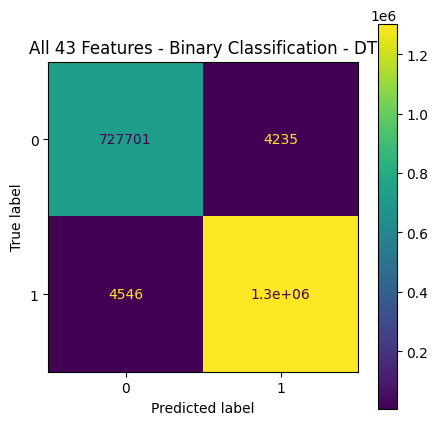

###############################################################
Binary Classification - Paper 18 - DT
###############################################################
Training Time: 17.103837966918945s
Prediction Time for 2037891 records: 0.28673410415649414s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       0.89      0.98      0.93    731936
Class 1: Attack       0.99      0.93      0.96   1305955

       accuracy                           0.95   2037891
      macro avg       0.94      0.95      0.94   2037891
   weighted avg       0.95      0.95      0.95   2037891



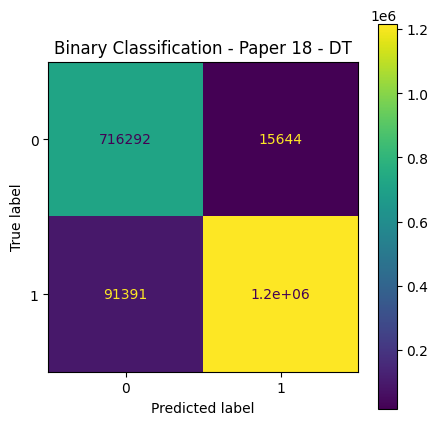

###############################################################
Binary Classification - Paper 19 - DT
###############################################################
Training Time: 11.629541397094727s
Prediction Time for 2037891 records: 0.2791285514831543s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       1.00      0.99      0.99    731936
Class 1: Attack       1.00      1.00      1.00   1305955

       accuracy                           1.00   2037891
      macro avg       1.00      1.00      1.00   2037891
   weighted avg       1.00      1.00      1.00   2037891



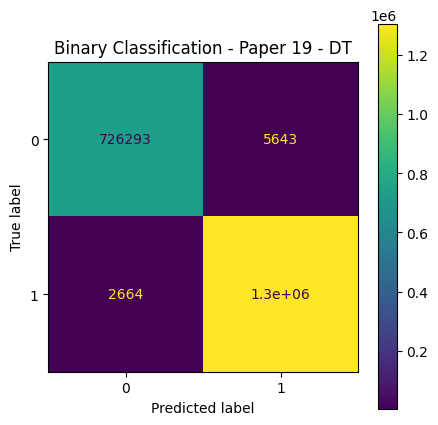

###############################################################
Binary Classification - Paper 20 - DT
###############################################################
Training Time: 34.10697317123413s
Prediction Time for 2037891 records: 0.3642301559448242s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       0.99      0.99      0.99    731936
Class 1: Attack       1.00      1.00      1.00   1305955

       accuracy                           1.00   2037891
      macro avg       1.00      1.00      1.00   2037891
   weighted avg       1.00      1.00      1.00   2037891



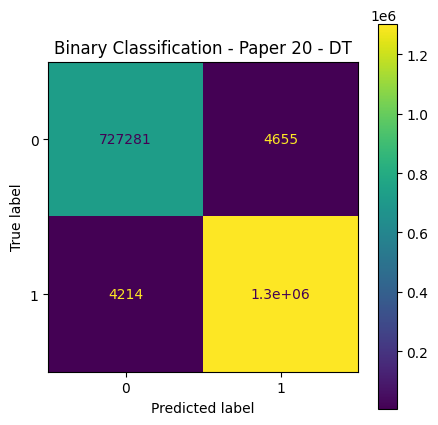

In [12]:
# Decision Tree Classifier - Binary
counter = 0
for subset in proposedBinarySubsets:
    print("###############################################################")
    print(binaryTextLabels[counter] + " - DT")
    print("###############################################################")
    evaluateModel(DecisionTreeClassifier(), netFlowDataset[subset], netFlowLabels, binaryClassificationLabels, binaryTextLabels[counter] + " - DT",True)
    counter = counter + 1

###############################################################
All 43 Features - Multi-Classification - DT
###############################################################
Training Time: 61.911367893218994s
Prediction Time for 2037891 records: 0.9832074642181396s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       0.99      0.99      0.99    731936
  Class 1: backdoor       1.00      1.00      1.00      5043
      Class 2: ddos       0.99      0.99      0.99    243148
       Class 3: dos       0.88      0.89      0.89     85513
 Class 4: injection       0.89      0.89      0.89     82136
      Class 5: mitm       0.60      0.59      0.60      2317
  Class 6: password       0.96      0.97      0.96    138399
Class 7: ransomware       0.97      0.98      0.98      1027
  Class 8: scanning       1.00      1.00      1.00    453770
       Class 9: xss       0.95      0.94      0.94    294602


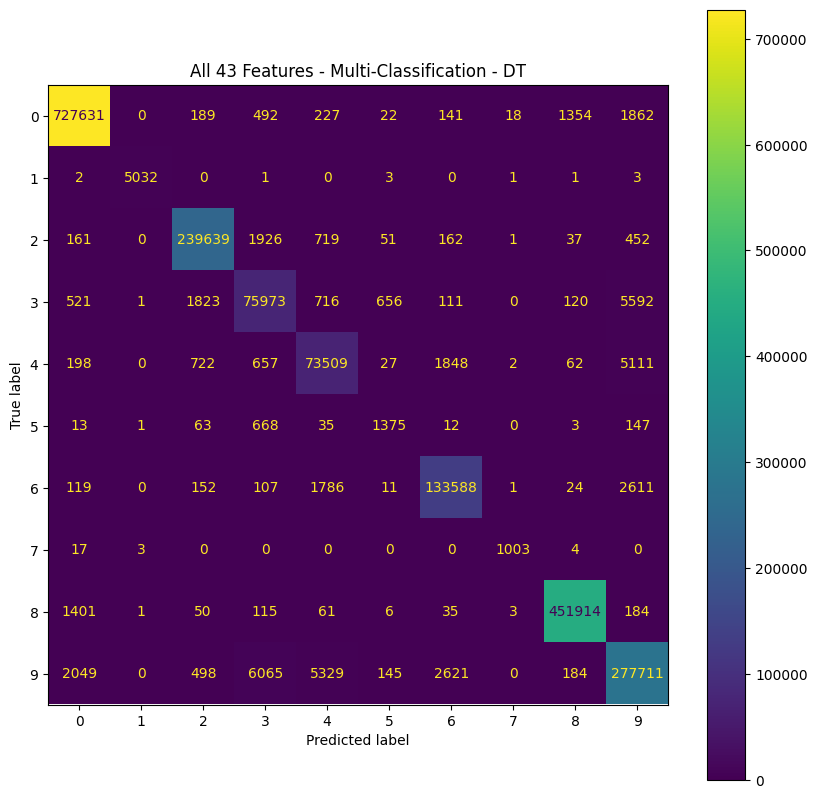

###############################################################
Multi-Classification - Paper 18 - DT
###############################################################
Training Time: 14.837032318115234s
Prediction Time for 2037891 records: 0.4171013832092285s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       0.89      0.98      0.93    731936
  Class 1: backdoor       1.00      0.99      0.99      5043
      Class 2: ddos       0.93      0.97      0.95    243148
       Class 3: dos       0.87      0.88      0.88     85513
 Class 4: injection       0.82      0.68      0.74     82136
      Class 5: mitm       0.46      0.38      0.42      2317
  Class 6: password       0.92      0.89      0.90    138399
Class 7: ransomware       0.98      0.96      0.97      1027
  Class 8: scanning       0.98      0.81      0.88    453770
       Class 9: xss       0.93      0.94      0.94    294602

      

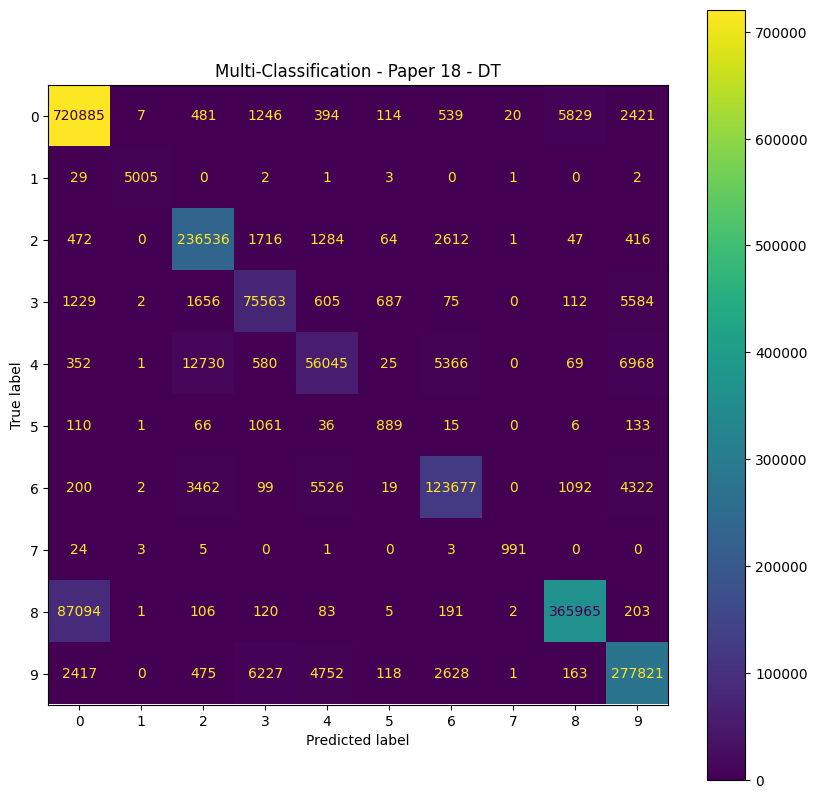

###############################################################
Multi-Classification - Paper 19 - DT
###############################################################
Training Time: 9.002350807189941s
Prediction Time for 2037891 records: 0.39537835121154785s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       1.00      0.99      0.99    731936
  Class 1: backdoor       1.00      0.99      1.00      5043
      Class 2: ddos       0.99      0.98      0.99    243148
       Class 3: dos       0.89      0.93      0.91     85513
 Class 4: injection       0.93      0.88      0.90     82136
      Class 5: mitm       0.89      0.36      0.51      2317
  Class 6: password       0.96      0.96      0.96    138399
Class 7: ransomware       0.97      0.97      0.97      1027
  Class 8: scanning       1.00      1.00      1.00    453770
       Class 9: xss       0.95      0.97      0.96    294602

      

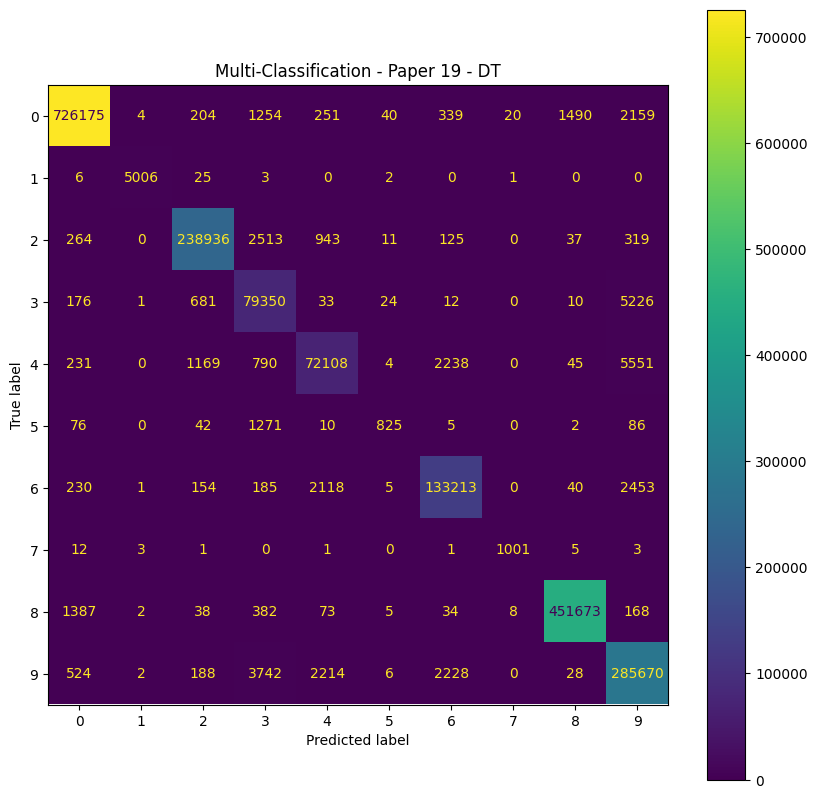

###############################################################
Multi-Classification - Paper 20 - DT
###############################################################
Training Time: 34.759628772735596s
Prediction Time for 2037891 records: 0.6226398944854736s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       0.99      0.99      0.99    731936
  Class 1: backdoor       1.00      1.00      1.00      5043
      Class 2: ddos       0.99      0.99      0.99    243148
       Class 3: dos       0.91      0.90      0.90     85513
 Class 4: injection       0.90      0.90      0.90     82136
      Class 5: mitm       0.72      0.76      0.74      2317
  Class 6: password       0.96      0.96      0.96    138399
Class 7: ransomware       0.98      0.98      0.98      1027
  Class 8: scanning       1.00      1.00      1.00    453770
       Class 9: xss       0.95      0.95      0.95    294602

      

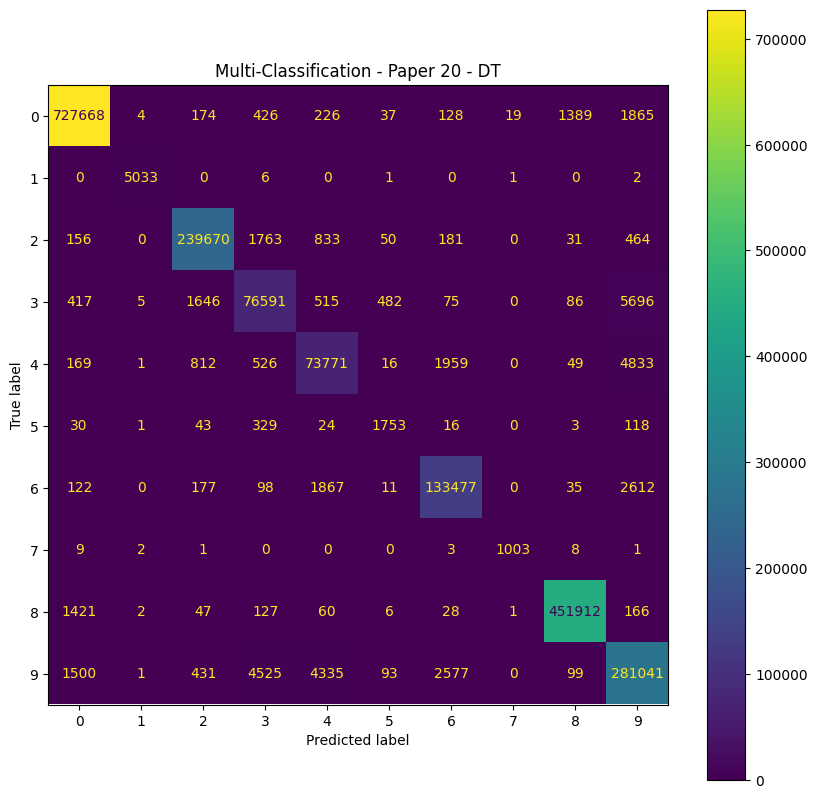

In [13]:
# Decision Tree Classifier - Multi
counter = 0
for subset in proposedMultiSubsets:
    print("###############################################################")
    print(multiTextLabels[counter] + " - DT")
    print("###############################################################")
    evaluateModel(DecisionTreeClassifier(), netFlowDataset[subset], netFlowAttacks, multiClassificationLabels, multiTextLabels[counter] + " - DT",False)
    counter = counter + 1

###############################################################
All 43 Features - Binary Classification - RF
###############################################################
Training Time: 759.3725244998932s
Prediction Time for 2037891 records: 28.10537838935852s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       0.97      0.98      0.97    731936
Class 1: Attack       0.99      0.98      0.99   1305955

       accuracy                           0.98   2037891
      macro avg       0.98      0.98      0.98   2037891
   weighted avg       0.98      0.98      0.98   2037891



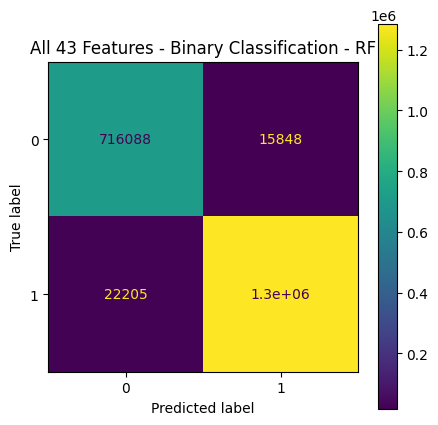

###############################################################
Binary Classification - Paper 18 - RF
###############################################################
Training Time: 414.1146562099457s
Prediction Time for 2037891 records: 25.37367582321167s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       0.89      0.97      0.92    731936
Class 1: Attack       0.98      0.93      0.95   1305955

       accuracy                           0.94   2037891
      macro avg       0.93      0.95      0.94   2037891
   weighted avg       0.95      0.94      0.94   2037891



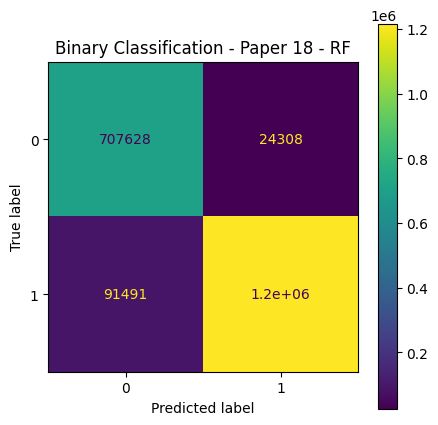

###############################################################
Binary Classification - Paper 19 - RF
###############################################################
Training Time: 437.564749956131s
Prediction Time for 2037891 records: 25.69021511077881s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       0.99      0.96      0.97    731936
Class 1: Attack       0.98      0.99      0.98   1305955

       accuracy                           0.98   2037891
      macro avg       0.98      0.97      0.98   2037891
   weighted avg       0.98      0.98      0.98   2037891



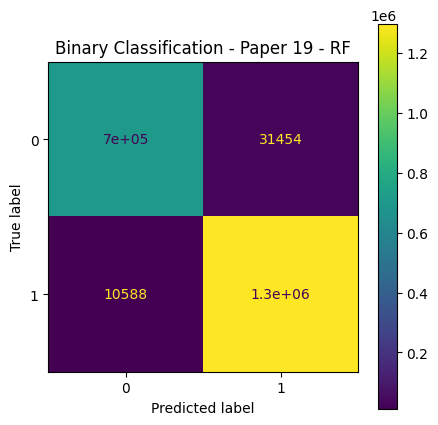

###############################################################
Binary Classification - Paper 20 - RF
###############################################################
Training Time: 655.9222812652588s
Prediction Time for 2037891 records: 25.10275101661682s
###############################################################
                 precision    recall  f1-score   support

Class 0: Benign       0.98      0.97      0.98    731936
Class 1: Attack       0.98      0.99      0.99   1305955

       accuracy                           0.98   2037891
      macro avg       0.98      0.98      0.98   2037891
   weighted avg       0.98      0.98      0.98   2037891



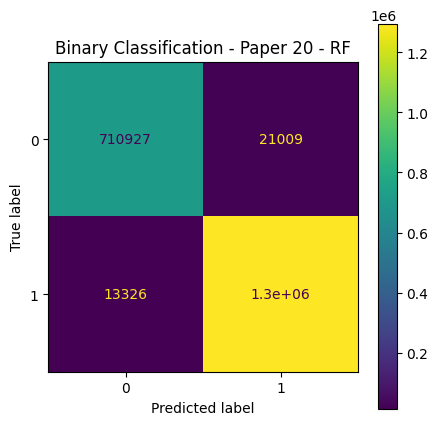

In [14]:
# Random Forest Classifier - Binary
counter = 0
for subset in proposedBinarySubsets:
    print("###############################################################")
    print(binaryTextLabels[counter] + " - RF")
    print("###############################################################")
    evaluateModel(rfModel, netFlowDataset[subset], netFlowLabels, binaryClassificationLabels, binaryTextLabels[counter] + " - RF", True)
    counter = counter + 1

###############################################################
All 43 Features - Multi-Classification - RF
###############################################################
Training Time: 793.3767607212067s
Prediction Time for 2037891 records: 47.31261944770813s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       0.95      0.99      0.97    731936
  Class 1: backdoor       1.00      0.99      0.99      5043
      Class 2: ddos       0.89      0.97      0.93    243148
       Class 3: dos       0.89      0.93      0.91     85513
 Class 4: injection       0.95      0.50      0.66     82136
      Class 5: mitm       1.00      0.28      0.44      2317
  Class 6: password       0.89      0.89      0.89    138399
Class 7: ransomware       0.98      0.68      0.80      1027
  Class 8: scanning       0.99      0.91      0.95    453770
       Class 9: xss       0.91      0.96      0.93    294602

 

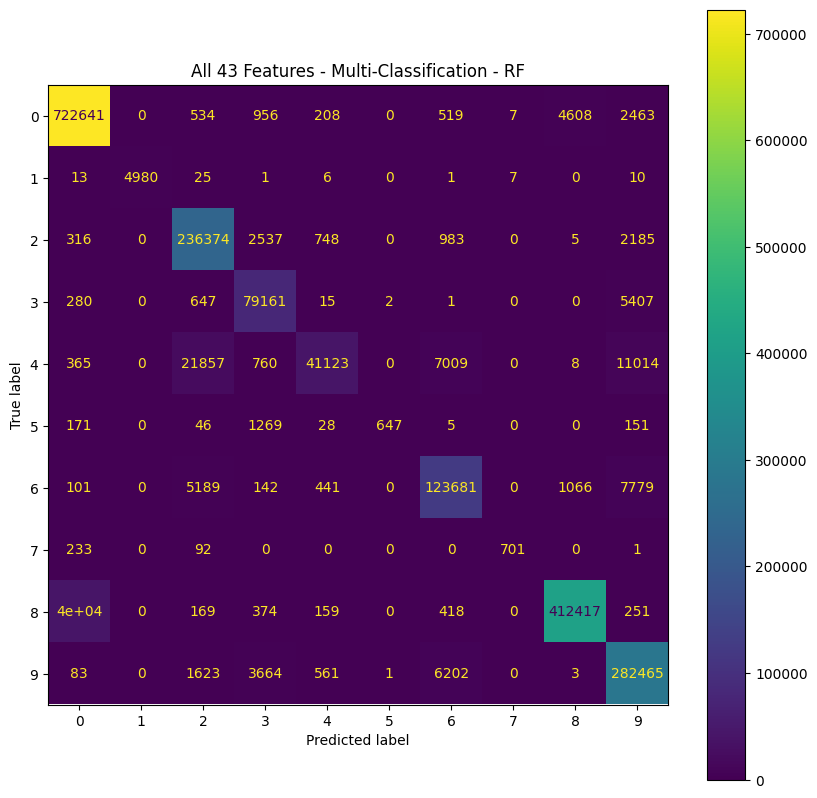

###############################################################
Multi-Classification - Paper 18 - RF
###############################################################
Training Time: 428.5640962123871s
Prediction Time for 2037891 records: 42.262699842453s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       0.88      0.98      0.93    731936
  Class 1: backdoor       1.00      0.99      0.99      5043
      Class 2: ddos       0.89      0.96      0.92    243148
       Class 3: dos       0.90      0.81      0.85     85513
 Class 4: injection       0.88      0.33      0.48     82136
      Class 5: mitm       1.00      0.26      0.42      2317
  Class 6: password       0.78      0.77      0.77    138399
Class 7: ransomware       0.99      0.59      0.74      1027
  Class 8: scanning       0.98      0.79      0.88    453770
       Class 9: xss       0.84      0.97      0.90    294602

          

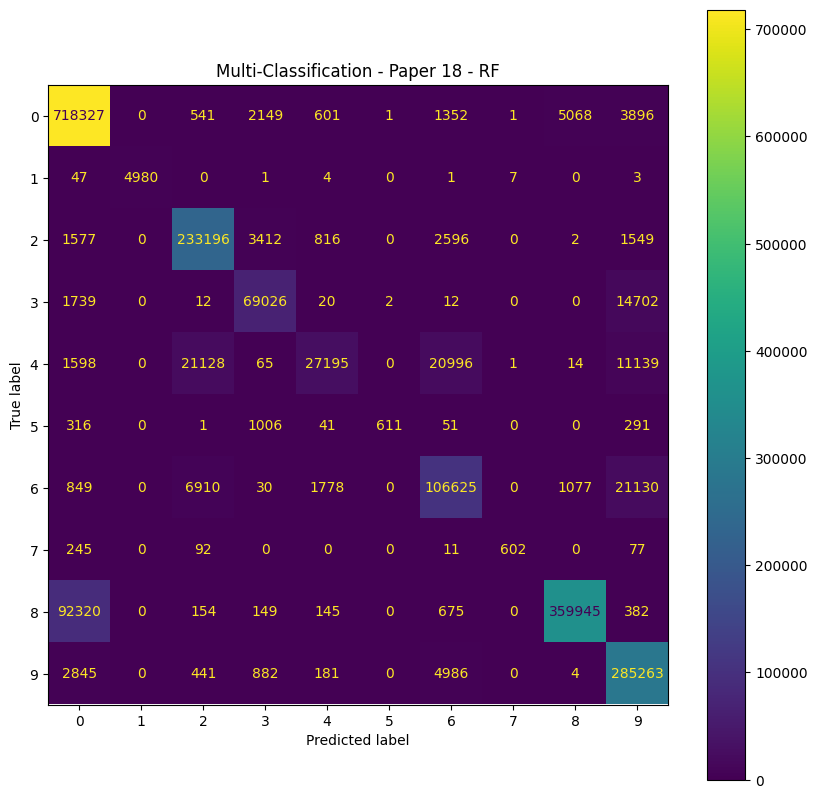

###############################################################
Multi-Classification - Paper 19 - RF
###############################################################
Training Time: 452.90846943855286s
Prediction Time for 2037891 records: 44.191489934921265s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       0.96      0.97      0.97    731936
  Class 1: backdoor       1.00      0.99      0.99      5043
      Class 2: ddos       0.91      0.97      0.94    243148
       Class 3: dos       0.92      0.90      0.91     85513
 Class 4: injection       0.92      0.50      0.64     82136
      Class 5: mitm       0.99      0.26      0.41      2317
  Class 6: password       0.83      0.88      0.86    138399
Class 7: ransomware       1.00      0.53      0.69      1027
  Class 8: scanning       0.97      0.96      0.97    453770
       Class 9: xss       0.90      0.95      0.92    294602

      

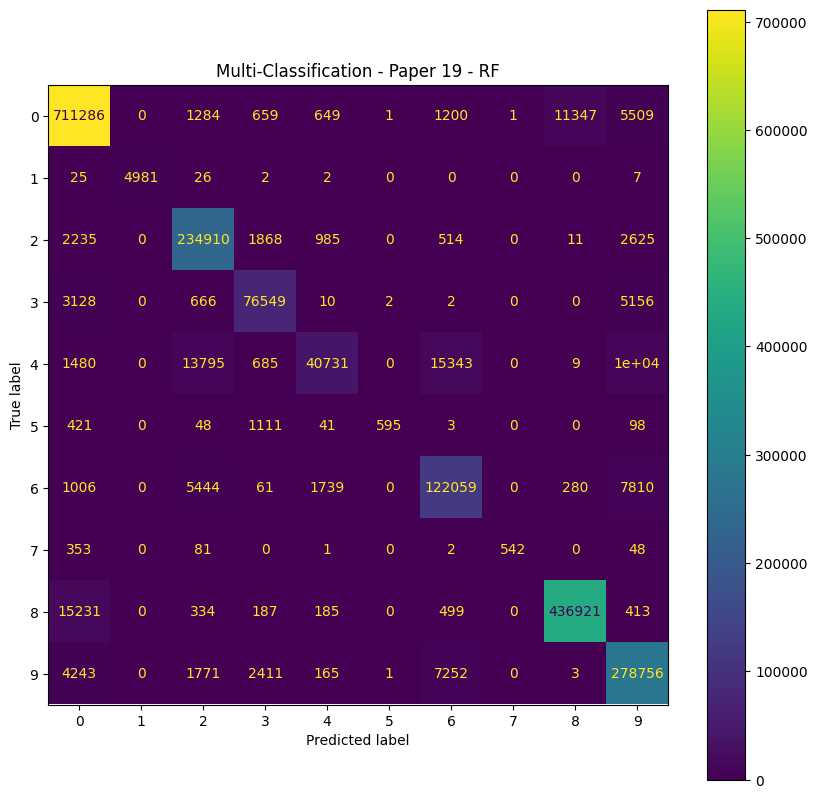

###############################################################
Multi-Classification - Paper 20 - RF
###############################################################
Training Time: 774.4965870380402s
Prediction Time for 2037891 records: 41.99091672897339s
###############################################################
                     precision    recall  f1-score   support

    Class 0: Benign       0.97      0.98      0.98    731936
  Class 1: backdoor       1.00      0.99      0.99      5043
      Class 2: ddos       0.89      0.97      0.93    243148
       Class 3: dos       0.89      0.93      0.91     85513
 Class 4: injection       0.94      0.44      0.60     82136
      Class 5: mitm       1.00      0.27      0.43      2317
  Class 6: password       0.86      0.90      0.88    138399
Class 7: ransomware       0.98      0.69      0.81      1027
  Class 8: scanning       0.98      0.95      0.97    453770
       Class 9: xss       0.91      0.95      0.93    294602

        

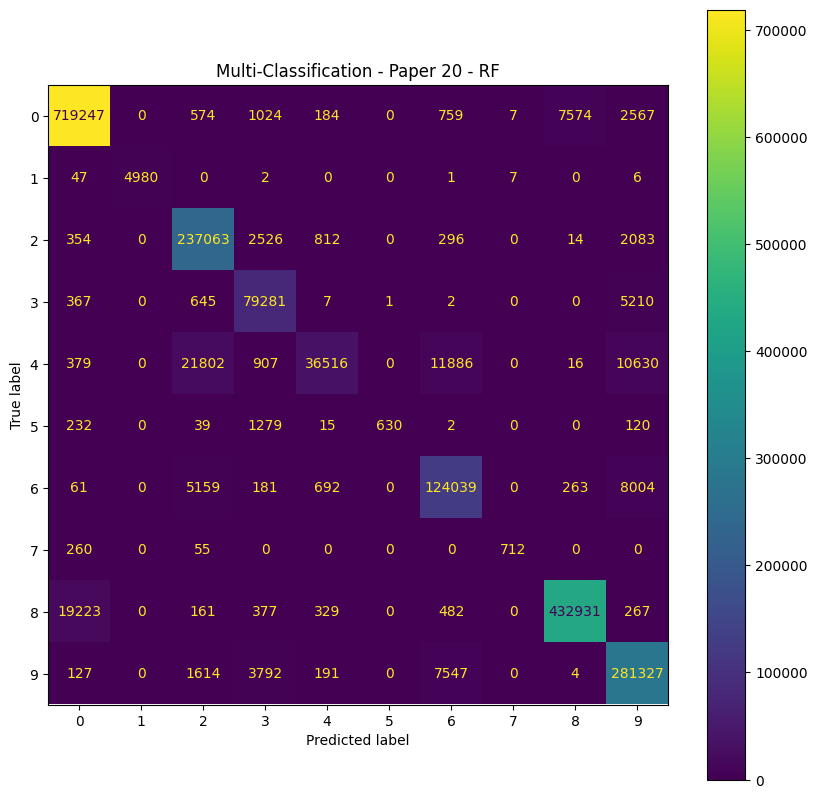

In [16]:
# Random Forest Classifier - Multi
counter = 0
for subset in proposedMultiSubsets:
    print("###############################################################")
    print(multiTextLabels[counter] + " - RF")
    print("###############################################################")
    evaluateModel(rfModel, netFlowDataset[subset], netFlowAttacks, multiClassificationLabels, multiTextLabels[counter] + " - RF", False)
    counter = counter + 1

In [ ]:
# Final Model For Binary Classification
model = evaluateModel(DecisionTreeClassifier(), paper19Features, netFlowLabels, binaryClassificationLabels, binaryTextLabels[2] + " - DT",True)

## ANN

In [9]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
scaler = MinMaxScaler()

In [22]:
netFlowDatasetScaled = scaler.fit_transform(netFlowDataset)
netFlowDatasetScaled = pd.DataFrame(netFlowDatasetScaled,columns=netFlowDataset.columns)
netFlowDataset = []

In [23]:
netFlowDatasetScaled.to_csv("Data Sets/NF-ToN-IoT-v2-Scaled", index=False)

In [ ]:
netFlowDatasetScaled = pd.read_csv("Data Sets/NF-ToN-IoT-v2-Scaled")

In [24]:
netFlowDatasetScaled.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
0,0.752566,0.666545,0.752564,0.001221,0.087719,0.028226,5.034343e-06,0.000011,6.487553e-06,0.000017,...,0.000057,0.000005,0.445563,0.441901,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.752566,0.785885,0.752564,0.101411,0.087719,0.000000,1.324827e-07,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.015625,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,0.752566,0.635691,0.752564,0.000809,0.280702,0.000000,2.020361e-07,0.000000,4.924946e-07,0.000004,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.330068,0.003922,0.000119,0.0
3,0.752566,0.523354,0.752564,0.001221,0.087719,0.028226,2.096539e-06,0.000009,4.140603e-06,0.000013,...,0.000057,0.000000,0.445563,0.441901,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,0.752566,0.693477,0.752566,0.001221,0.087719,0.028226,1.192344e-07,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.015625,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [42]:
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping


def evaluateModelCV(model, dataset, labels, displayLabels, name, bin):
    skf = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)
    
    scoring = ['loss', 'accuracy']
    
    scores = {'loss': [], 'accuracy': []}
    
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
    
    for train_index, test_index in skf.split(dataset, labels):
        xTrain, xTest = dataset.iloc[train_index], dataset.iloc[test_index]
        yTrain, yTest = (labels.iloc[train_index], labels.iloc[test_index]) if bin else (labels[train_index], labels[test_index])

        if bin:
            yTrainEncoded = yTrain
            yTestEncoded = yTest
        else:
            yTrainEncoded = pd.get_dummies(yTrain)
            yTestEncoded = pd.get_dummies(yTest)
        
        model.fit(xTrain, yTrainEncoded, epochs=16, batch_size=20, callbacks=[early_stop], verbose=0)
        scores_fold = model.evaluate(xTest, yTestEncoded)

        #print(f'Scores fold: {scores_fold}')
        
        for i, metric in enumerate(scoring):
            scores[metric].append(scores_fold[i])
    
    print(f"{name} - Cross Validation Results:")
    for metric in scoring:
        mean_score = np.mean(scores[metric])
        print(f"{metric.capitalize()}: {mean_score:.4f}")



In [33]:
# ANN Classifier - Binary
counter = 0
for subset in proposedBinarySubsets:
    # Create the ANN model
    model = Sequential([
        Dense(64, input_dim=len(netFlowDatasetScaled[subset].columns), activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print("###############################################################")
    print(binaryTextLabels[counter] + " - ANN")
    print("###############################################################")
    evaluateModelCV(model, netFlowDatasetScaled[subset], netFlowLabels, binaryClassificationLabels, binaryTextLabels[counter] + " - ANN", True)
    counter = counter + 1

###############################################################
All 43 Features - Binary Classification - ANN
###############################################################
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 28s 666us/step - accuracy: 0.9891 - loss: 0.0351
Epoch 3: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 26s 621us/step - accuracy: 0.9893 - loss: 0.0330
Epoch 8: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 28s 664us/step - accuracy: 0.9898 - loss: 0.0343
Epoch 3: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 26s 618us/step - accuracy: 0.9895 - loss: 0.0346
Epoch 3: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 26s 613us/step - accuracy: 0.9896 - loss: 0.0326
All 43 Features - Binary Classification - ANN - Cross Validation Results:
Loss: 0.0333
Accuracy: 0.9895
###############################################################
Binary Classification - Paper 18 - ANN
###############################################################
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 26s 620us/step -

In [43]:
# ANN Classifier - Multi
xTrain, xTest, yTrain, yTest = [],[],[],[]
counter=0
for subset in proposedMultiSubsets:
    # Create the ANN model
    model = Sequential([
        Dense(64, input_dim=len(netFlowDatasetScaled[subset].columns), activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("###############################################################")
    print(multiTextLabels[counter] + " - ANN")
    print("###############################################################")
    evaluateModelCV(model, netFlowDatasetScaled[subset], netFlowAttacks, multiClassificationLabels, multiTextLabels[counter] + " - ANN", False)
    counter = counter + 1

###############################################################
All 43 Features - Multi-Classification - ANN
###############################################################
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 36s 832us/step - accuracy: 0.9576 - loss: 0.1435
Epoch 3: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 35s 823us/step - accuracy: 0.9501 - loss: 0.1507
Epoch 3: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 32s 759us/step - accuracy: 0.9526 - loss: 0.1595
Epoch 6: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 31s 719us/step - accuracy: 0.9604 - loss: 0.1501
Epoch 3: early stopping
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 51s 1ms/step - accuracy: 0.9583 - loss: 0.1392
All 43 Features - Multi-Classification - ANN - Cross Validation Results:
Loss: 0.1536
Accuracy: 0.9557
###############################################################
Multi-Classification - Paper 18 - ANN
###############################################################
42457/42457 ━━━━━━━━━━━━━━━━━━━━ 41s 934us/step - accu

In [47]:
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping

def evaluateANN(model, dataset, labels, displayLabels, name, bin):
    xTrain, xTest, yTrain, yTest = train_test_split(dataset, labels, test_size=0.3, random_state=50, stratify=labels)
    
    if bin:
        yTrainEncoded = yTrain
    else:
        yTrainEncoded = pd.get_dummies(yTrain)

    # Early stopping callback
    early_stop = EarlyStopping(monitor='accuracy', patience=3, verbose=1)

    begin = time.time()
    model.fit(xTrain, yTrainEncoded, epochs=16, batch_size=20, callbacks=[early_stop], validation_split=0.2)
    end = time.time()
    print("###############################################################")
    print(f"Training Time: {(end - begin)/60}m")

    begin = time.time()
    predictions = model.predict(xTest)
    end = time.time()
    print("###############################################################")
    print(f"Prediction Time for {len(xTest)} records: {end - begin}s")
    print("###############################################################")

    # predictions = np.argmax(predictions[0], axis=1)
    # predictions = predictions.flatten()    

    if bin:
        predictions = (predictions > 0.5).astype(int)
    else:
        predictions = np.argmax(predictions, axis=1)


    results = classification_report(yTest, predictions, target_names=displayLabels)
    print(results)

    # Produces a confusion matrix based on the original targets against the predicted targets
    cm = confusion_matrix(yTest, predictions)
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.rcParams['figure.figsize'] = [5,5] if bin else [10, 10]
    cmDisplay.plot()
    plt.title(name)
    plt.show()
    return predictions


###############################################################
All 43 Features - Binary Classification - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 191s 989us/step - accuracy: 0.9682 - loss: 0.0904 - val_accuracy: 0.9840 - val_loss: 0.0466
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 186s 979us/step - accuracy: 0.9836 - loss: 0.0462 - val_accuracy: 0.9817 - val_loss: 0.0470
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - accuracy: 0.9853 - loss: 0.0420 - val_accuracy: 0.9865 - val_loss: 0.0387
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - accuracy: 0.9863 - loss: 0.0398 - val_accuracy: 0.9863 - val_loss: 0.0390
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 187s 981us/step - accuracy: 0.9868 - loss: 0.0383 - val_accuracy: 0.9874 - val_loss: 0.0379
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 187s 983us/step - accuracy: 0.9874 - loss: 0.0370 - val_accuracy: 0.9873 - val_loss: 0.0363
Ep

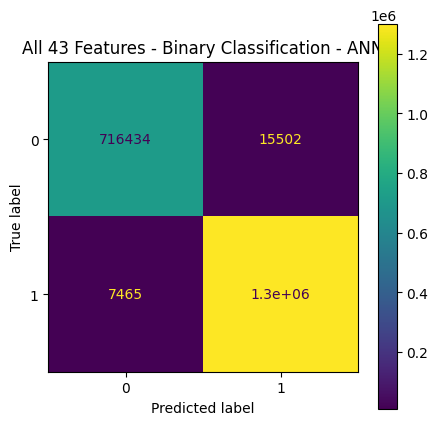

###############################################################
Binary Classification - Paper 18 - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 179s 936us/step - accuracy: 0.9079 - loss: 0.2643 - val_accuracy: 0.9294 - val_loss: 0.1986
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 177s 932us/step - accuracy: 0.9318 - loss: 0.2006 - val_accuracy: 0.9365 - val_loss: 0.1978
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 178s 935us/step - accuracy: 0.9345 - loss: 0.1941 - val_accuracy: 0.9350 - val_loss: 0.1894
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 182s 958us/step - accuracy: 0.9363 - loss: 0.1898 - val_accuracy: 0.9337 - val_loss: 0.1933
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 180s 946us/step - accuracy: 0.9371 - loss: 0.1869 - val_accuracy: 0.9353 - val_loss: 0.1861
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 177s 932us/step - accuracy: 0.9375 - loss: 0.1856 - val_accuracy: 0.9374 - val_loss: 0.1847
Epoch

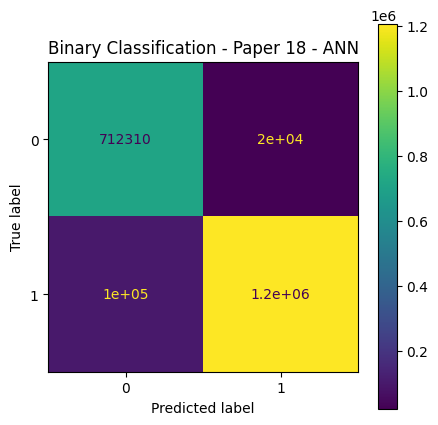

###############################################################
Binary Classification - Paper 19 - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 178s 933us/step - accuracy: 0.9314 - loss: 0.1802 - val_accuracy: 0.9636 - val_loss: 0.1063
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 179s 939us/step - accuracy: 0.9527 - loss: 0.1243 - val_accuracy: 0.9599 - val_loss: 0.1137
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 183s 959us/step - accuracy: 0.9613 - loss: 0.1053 - val_accuracy: 0.9671 - val_loss: 0.0885
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 180s 945us/step - accuracy: 0.9672 - loss: 0.0916 - val_accuracy: 0.9691 - val_loss: 0.0885
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 180s 946us/step - accuracy: 0.9686 - loss: 0.0882 - val_accuracy: 0.9708 - val_loss: 0.0792
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 179s 942us/step - accuracy: 0.9691 - loss: 0.0866 - val_accuracy: 0.9717 - val_loss: 0.0800
Epoch

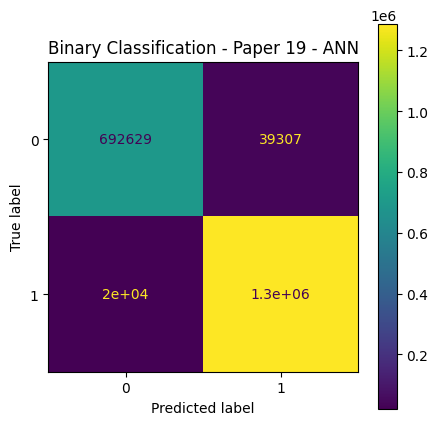

###############################################################
Binary Classification - Paper 20 - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 188s 981us/step - accuracy: 0.9527 - loss: 0.1312 - val_accuracy: 0.9748 - val_loss: 0.0656
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 177s 929us/step - accuracy: 0.9761 - loss: 0.0685 - val_accuracy: 0.9773 - val_loss: 0.0656
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 178s 933us/step - accuracy: 0.9782 - loss: 0.0628 - val_accuracy: 0.9815 - val_loss: 0.0555
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 177s 928us/step - accuracy: 0.9796 - loss: 0.0591 - val_accuracy: 0.9820 - val_loss: 0.0543
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 176s 927us/step - accuracy: 0.9807 - loss: 0.0565 - val_accuracy: 0.9825 - val_loss: 0.0586
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 187s 983us/step - accuracy: 0.9817 - loss: 0.0542 - val_accuracy: 0.9805 - val_loss: 0.0524
Epoch

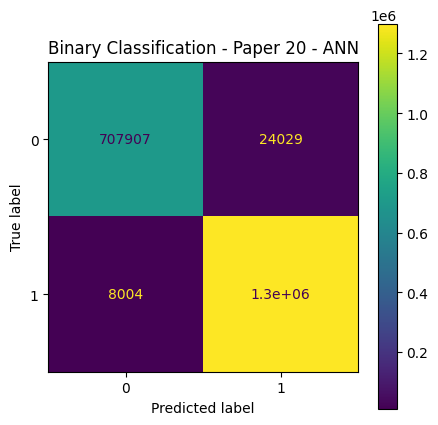

In [45]:
# ANN Classifier - Binary
counter = 0
ANNBinaryCMs = []
for subset in proposedBinarySubsets:
    # Create the ANN model
    model = Sequential([
        Dense(64, input_dim=len(netFlowDatasetScaled[subset].columns), activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print("###############################################################")
    print(binaryTextLabels[counter] + " - ANN")
    print("###############################################################")
    evaluateANN(model, netFlowDatasetScaled[subset], netFlowLabels, binaryClassificationLabels, binaryTextLabels[counter] + " - ANN", True)
    counter = counter + 1

###############################################################
All 43 Features - Multi-Classification - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 224s 1ms/step - accuracy: 0.8652 - loss: 0.3557 - val_accuracy: 0.9279 - val_loss: 0.1952
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 232s 1ms/step - accuracy: 0.9326 - loss: 0.1927 - val_accuracy: 0.9398 - val_loss: 0.1806
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 230s 1ms/step - accuracy: 0.9405 - loss: 0.1746 - val_accuracy: 0.9496 - val_loss: 0.1618
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 259s 1ms/step - accuracy: 0.9451 - loss: 0.1632 - val_accuracy: 0.9376 - val_loss: 0.1707
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 250s 1ms/step - accuracy: 0.9476 - loss: 0.1583 - val_accuracy: 0.9481 - val_loss: 0.1623
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 246s 1ms/step - accuracy: 0.9490 - loss: 0.1543 - val_accuracy: 0.9474 - val_loss: 0.1604
Epoch 7/16


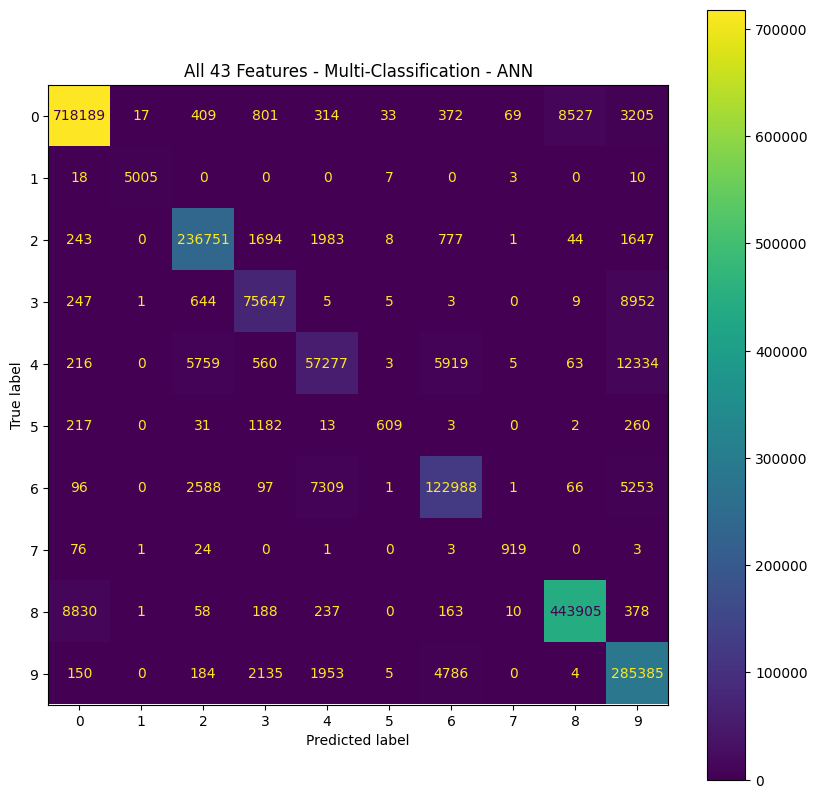

###############################################################
Multi-Classification - Paper 18 - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 190s 990us/step - accuracy: 0.7635 - loss: 0.6604 - val_accuracy: 0.8416 - val_loss: 0.4801
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 185s 970us/step - accuracy: 0.8325 - loss: 0.4740 - val_accuracy: 0.8445 - val_loss: 0.4456
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 206s 1ms/step - accuracy: 0.8436 - loss: 0.4420 - val_accuracy: 0.8497 - val_loss: 0.4374
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 222s 1ms/step - accuracy: 0.8509 - loss: 0.4245 - val_accuracy: 0.8622 - val_loss: 0.4128
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 212s 1ms/step - accuracy: 0.8571 - loss: 0.4123 - val_accuracy: 0.8677 - val_loss: 0.4209
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 208s 1ms/step - accuracy: 0.8614 - loss: 0.4031 - val_accuracy: 0.8640 - val_loss: 0.3963
Epoch 7/16
190

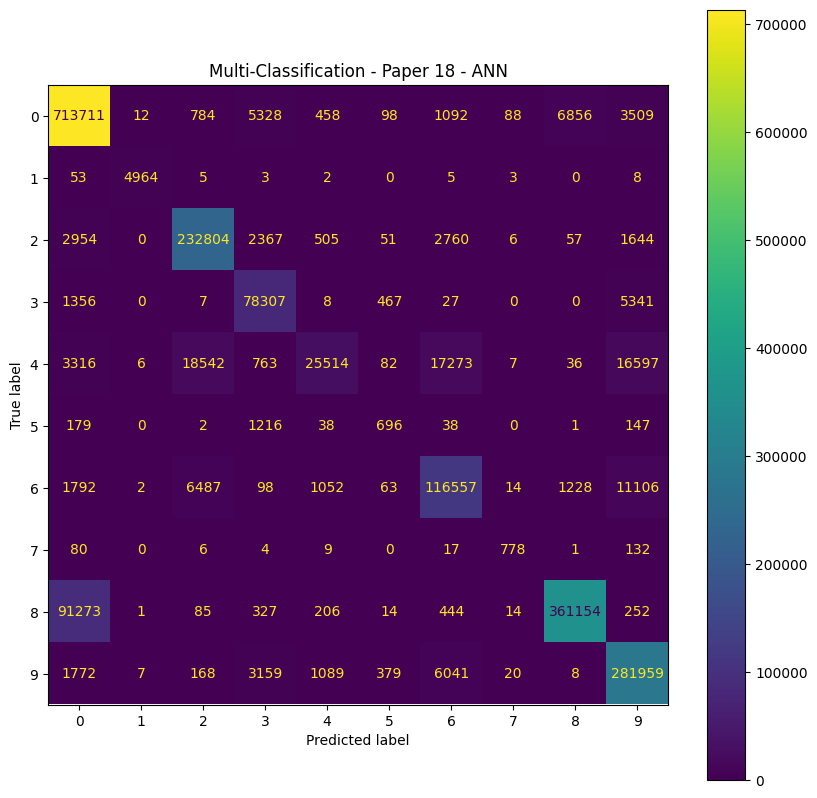

###############################################################
Multi-Classification - Paper 19 - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 199s 1ms/step - accuracy: 0.8006 - loss: 0.5373 - val_accuracy: 0.8517 - val_loss: 0.3717
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 189s 991us/step - accuracy: 0.8719 - loss: 0.3544 - val_accuracy: 0.8842 - val_loss: 0.3140
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 190s 997us/step - accuracy: 0.8918 - loss: 0.3062 - val_accuracy: 0.9066 - val_loss: 0.2820
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 189s 990us/step - accuracy: 0.9063 - loss: 0.2774 - val_accuracy: 0.9048 - val_loss: 0.2667
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 185s 971us/step - accuracy: 0.9089 - loss: 0.2699 - val_accuracy: 0.9024 - val_loss: 0.2823
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 238s 1ms/step - accuracy: 0.9146 - loss: 0.2567 - val_accuracy: 0.9245 - val_loss: 0.2419
Epoch 7/16

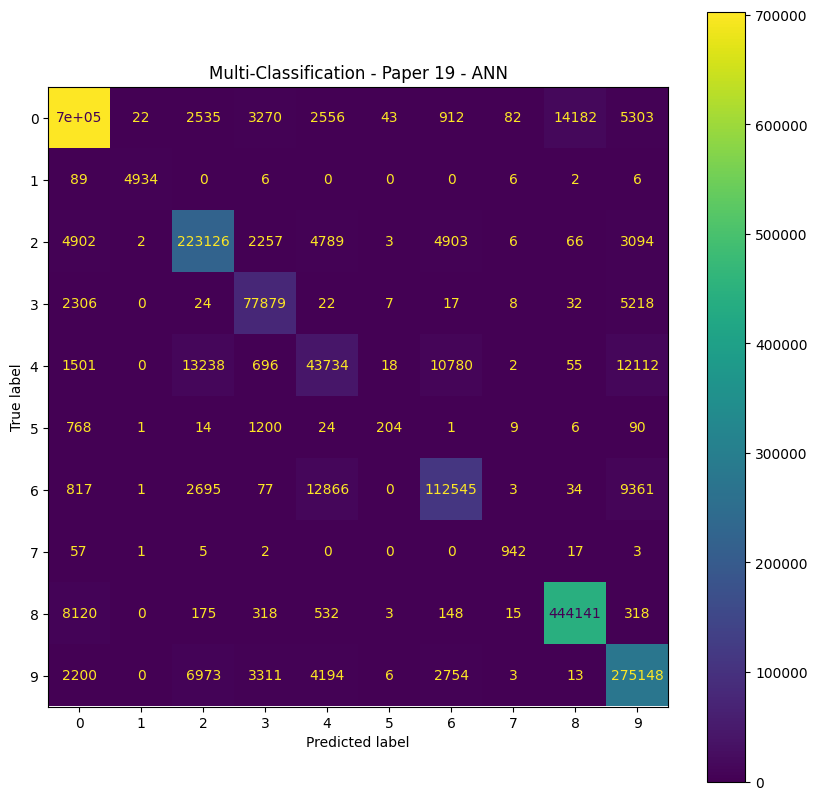

###############################################################
Multi-Classification - Paper 20 - ANN
###############################################################
Epoch 1/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 257s 1ms/step - accuracy: 0.8481 - loss: 0.4186 - val_accuracy: 0.9196 - val_loss: 0.2504
Epoch 2/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 254s 1ms/step - accuracy: 0.9126 - loss: 0.2426 - val_accuracy: 0.9080 - val_loss: 0.2164
Epoch 3/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 257s 1ms/step - accuracy: 0.9186 - loss: 0.2222 - val_accuracy: 0.9047 - val_loss: 0.2291
Epoch 4/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 256s 1ms/step - accuracy: 0.9241 - loss: 0.2098 - val_accuracy: 0.9280 - val_loss: 0.2009
Epoch 5/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 257s 1ms/step - accuracy: 0.9277 - loss: 0.2050 - val_accuracy: 0.9277 - val_loss: 0.2081
Epoch 6/16
190204/190204 ━━━━━━━━━━━━━━━━━━━━ 260s 1ms/step - accuracy: 0.9295 - loss: 0.1990 - val_accuracy: 0.9270 - val_loss: 0.2006
Epoch 7/16
190204/

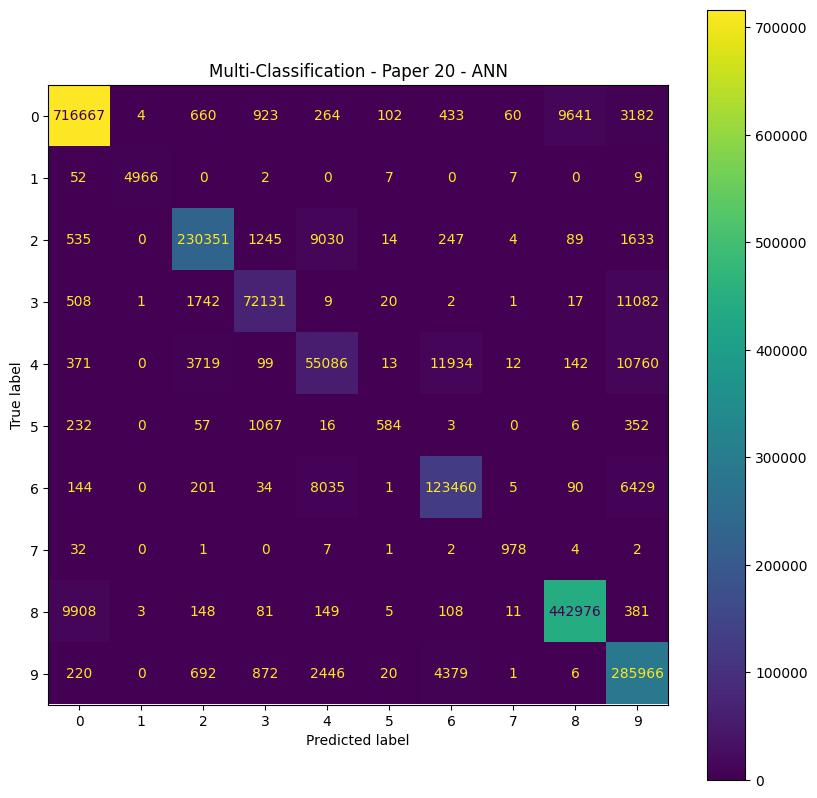

In [48]:
# ANN Classifier - Multi
counter = 0
xTrain, xTest, yTrain, yTest = [],[],[],[]
for subset in proposedMultiSubsets:
    # Create the ANN model
    model = Sequential([
        Dense(64, input_dim=len(netFlowDatasetScaled[subset].columns), activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("###############################################################")
    print(multiTextLabels[counter] + " - ANN")
    print("###############################################################")
    evaluateANN(model, netFlowDatasetScaled[subset], netFlowAttacks, multiClassificationLabels, multiTextLabels[counter] + " - ANN", False)
    counter = counter + 1